In [1]:
"""

1. Optimize corrrelation coefficients between glacier ice exposure and a) air temperature and b) snowfall

"""

# Import libraries
import glob
import os
import numpy as np
import xarray as xr
import netCDF4
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Define base path
path = '/Users/jryan4/Dropbox (University of Oregon)/research/snowfall/data/'

In [3]:
# Read data
index_data = xr.open_dataset(path + 'masks/index_main.nc')

# Define maximum snowline
snowline_file = netCDF4.Dataset(path + 'masks/monthly_bare_ice_2012.nc')
snowline = snowline_file.variables['bare_ice'][1, :, :].filled(np.nan)
max_snowline = (snowline > 0.1)

# Define indices
index = list(zip(index_data['index_x'].values, index_data['index_y'].values))

# Define MERRA and exposure files
merra_snow_files = sorted(glob.glob(path + 'merra_snowfall_modern/*.nc'))
merra_temp_files = sorted(glob.glob(path + 'merra_t2m_modern/*.nc'))
expo_files = sorted(glob.glob(path + 'modis_exposure_v2/*.nc'))

# Define regions
regions = np.arange(1, 9)

# Define days before first day of glacier ice exposure
t_days = np.arange(121, 183)
s_days = np.arange(90, 183)

# Define days before last day of glacier ice exposure
l_days = np.arange(183, 243)

# Define number of years
years = np.arange(2001, 2022, 1)

In [ ]:
# Optimize temperature before July 2 (day-of-year = 183)
mean_exposure = []
mean_temp = []
for i in range(len(years)):
    temp = xr.open_dataset(merra_temp_files[i])
    expo = xr.open_dataset(expo_files[i])
    print(i)
    # Mask ablation zone
    abl_expo = expo['first_55'].values[max_snowline].astype(float)
    abl_expo[abl_expo == 0] = np.nan
    abl_expo[abl_expo < 151] = np.nan
    
    # Mean date of exposure between Jun 1 and August 31
    # Mask region and find mean temperature between May 01 and Jul 02
    region_exposure = []
    region_temp = []
    for region in regions:
        region_mask = index_data['region'].values == region
        region_exposure.append(np.nanmedian(abl_expo[region_mask]))
        
        region_temp_day = []
        for day in t_days:
            region_temp_day.append(np.nanmean(np.mean(temp['t2m'][day:183, :], axis=0)[region_mask]))
        region_temp.append(region_temp_day)
                                   
    mean_exposure.append(region_exposure)
    mean_temp.append(region_temp)

In [ ]:
# Optimize snowfall before July 2 (day-of-year = 183)
mean_snow = []
for i in range(len(years)):
    snow = xr.open_dataset(merra_snow_files[i])
    print(i)
    # Mask region and find mean snowfall between Jan 1 and Jul 2
    region_snow = []
    for region in regions:
        region_mask = index_data['region'].values == region
        
        region_snow_day = []
        for day in s_days:
            region_snow_day.append(np.nanmean(np.mean(snow['snowfall'][day:183, :], axis=0)[region_mask]) * 86400 * 365 / 1000)
        region_snow.append(region_snow_day)

    mean_snow.append(region_snow)

In [22]:
df_exposure= pd.DataFrame(mean_exposure, columns=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
df_temp = np.array(mean_temp)
df_snow = np.array(mean_snow)

In [23]:
# Compute correlation coefficients
coeffs = []
for r in np.arange(0, 8):
    region_coeff = []
    for i in range(df_temp.shape[2]):
        s1, i1, r1, p1, e1 = stats.linregress(df_temp[:,r,i], df_exposure.iloc[:,r])
        region_coeff.append(r1**2)
    coeffs.append(region_coeff)
df_coeffs_temp = pd.DataFrame(coeffs).T
df_coeffs_temp.columns = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

In [28]:
# Compute correlation coefficients
coeffs = []
for r in np.arange(0, 8):
    region_coeff = []
    for i in range(df_snow.shape[2]):
        s1, i1, r1, p1, e1 = stats.linregress(df_snow[:,r,i], df_exposure.iloc[:,r])
        region_coeff.append(r1**2)
    coeffs.append(region_coeff)
df_coeffs_snow = pd.DataFrame(coeffs).T
df_coeffs_snow.columns = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

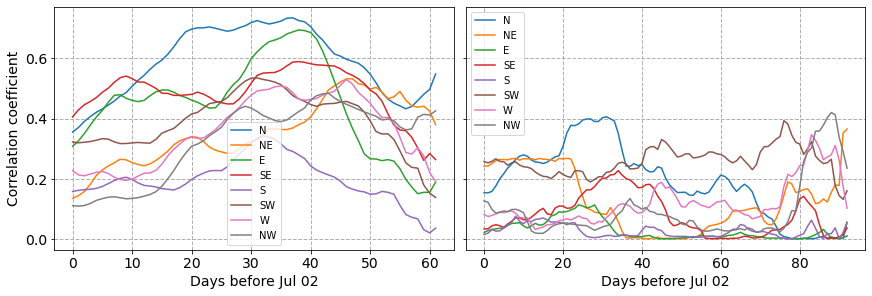

In [29]:
# Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True, layout='constrained')
for i in range(df_coeffs_temp.shape[1]):
    ax1.plot(df_coeffs_temp.iloc[:,i], label=df_coeffs_temp.iloc[:,i].name)
ax1.set_xlabel('Days before Jul 02', fontsize=14)
ax1.set_ylabel('Correlation coefficient', fontsize=14)
ax1.legend()

for i in range(df_coeffs_snow.shape[1]):
    ax2.plot(df_coeffs_snow.iloc[:,i], label=df_coeffs_snow.iloc[:,i].name)
ax2.set_xlabel('Days before Jul 02', fontsize=14)
ax2.legend()

for ax in [ax1, ax2]:
    ax.grid(ls='dashed', lw=1)
    ax.tick_params(axis='both', which='major', labelsize=14)

In [30]:
df_coeffs_temp.idxmax()

N     37
NE    47
E     38
SE    38
S     32
SW    31
W     46
NW    43
dtype: int64

In [31]:
df_coeffs_snow.idxmax()

N     31
NE    92
E     24
SE    34
S      8
SW    76
W     83
NW    88
dtype: int64

In [32]:
t_days[list(df_coeffs_temp.idxmax())]

array([158, 168, 159, 159, 153, 152, 167, 164])

In [33]:
s_days[list(df_coeffs_snow.idxmax())]

array([121, 182, 114, 124,  98, 166, 173, 178])

In [11]:
# Optimize snowfall before day of last ice exposure (day-of-year = 243)
mean_snow = []
last_exposure = []
for i in range(len(years)):
    snow = xr.open_dataset(merra_snow_files[i])
    expo = xr.open_dataset(expo_files[i])
    print(i)
    
    # Mask ablation zone
    abl_expo = expo['last_60'].values[max_snowline].astype(float)
    abl_expo[abl_expo == 0] = np.nan
    
    # Mask region and find mean snowfall between Jan 1 and Jul 2
    region_snow = []
    region_exposure = []
    for region in regions:
        region_mask = index_data['region'].values == region
        region_exposure.append(np.nanmedian(abl_expo[region_mask]))
        
        region_snow_day = []
        for day in l_days:
            region_snow_day.append(np.nanmean(np.mean(snow['snowfall'][day:244, :], axis=0)[region_mask]) * 86400 * 365 / 1000)
        region_snow.append(region_snow_day)

    mean_snow.append(region_snow)
    last_exposure.append(region_exposure)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [17]:
df_last = pd.DataFrame(last_exposure, columns=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
df_snow = np.array(mean_snow)

In [19]:
# Compute correlation coefficients
coeffs = []
for r in np.arange(0, 8):
    region_coeff = []
    for i in range(df_snow.shape[2]):
        s1, i1, r1, p1, e1 = stats.linregress(df_snow[:,r,i], df_last.iloc[:,r])
        region_coeff.append(r1**2)
    coeffs.append(region_coeff)
df_coeffs_snow = pd.DataFrame(coeffs).T
df_coeffs_snow.columns = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

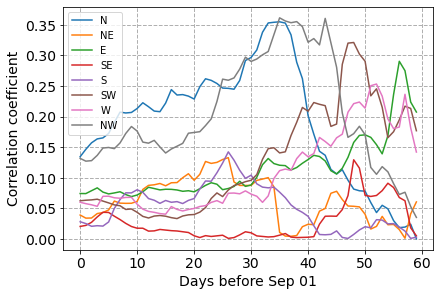

In [21]:
# Plot
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), layout='constrained')
for i in range(df_coeffs_snow.shape[1]):
    ax1.plot(df_coeffs_snow.iloc[:,i], label=df_coeffs_snow.iloc[:,i].name)
ax1.set_xlabel('Days before Sep 01', fontsize=14)
ax1.set_ylabel('Correlation coefficient', fontsize=14)
ax1.legend()

ax1.grid(ls='dashed', lw=1)
ax1.tick_params(axis='both', which='major', labelsize=14)